# Proyek Klasifikasi Gambar: Animals-10
- **Nama:** Lukas Krisna
- **Email:** lukaskrisnaaa@gmail.com
- **ID Dicoding:** lukas420

[Dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10) berisi 28.000 gambar hewan dengan 10 kelas: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant. Proyek klasifikasi gambar ini menggunakan metode transfer learning dengan model [MobileNetV2](https://arxiv.org/pdf/1801.04381) yang telah dilatih sebelumnya dan menambahkan lapisan khusus untuk mencapai akurasi yang tinggi.

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import zipfile
from google.colab import drive
import glob
import cv2

## Data Preparation

### Data Loading

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Extract datasets.zip dari Google Drive
zip_path = '/content/drive/MyDrive/datasets_image_classification.zip'
extract_path = '/content/data'

# Direktori baru jika belum dibuat
os.makedirs(extract_path, exist_ok=True)

Mounted at /content/drive


In [3]:
# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Datasets extracted to:", extract_path)

Datasets extracted to: /content/data


### Data Preprocessing

In [4]:
# Mengambil nama-nama kelas dari direktori
class_names = os.listdir(os.path.join(extract_path, 'datasets'))
print(f"Found {len(class_names)} classes: {class_names}")

Found 10 classes: ['cow', 'elephant', 'cat', 'butterfly', 'squirrel', 'chicken', 'sheep', 'dog', 'horse', 'spider']


#### Split Dataset

In [5]:
# Direktori baru untuk train, validation, dan test sets
data_root = '/content/data_split'
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'validation')
test_dir = os.path.join(data_root, 'test')

In [6]:
# Direktori baru tiap kelas pada train, validation, and test
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

In [7]:
# Konfigurasi awal
IMG_SIZE = 224  # MobileNetV2 default input size
BATCH_SIZE = 64
EPOCHS = 20
SPLIT_RATIO = (0.7, 0.15, 0.15)  # Rasio pembagian Train, Validation, Test

In [8]:
# Pembagian dan preprocess data
for class_name in class_names:
    # Ambil semua image path
    class_path = os.path.join(extract_path, 'datasets', class_name)
    image_paths = glob.glob(os.path.join(class_path, '*.*'))

    # Mengacak image path
    np.random.shuffle(image_paths)

    # Hitung indeks pembagian dari SPLIT_RATIO
    n = len(image_paths)
    train_end = int(n * SPLIT_RATIO[0])
    val_end = train_end + int(n * SPLIT_RATIO[1])

    # Pembagian data
    train_images = image_paths[:train_end]
    val_images = image_paths[train_end:val_end]
    test_images = image_paths[val_end:]

    # Menyalin gambar ke direktori masing-masing dengan preprocessing
    for subset, paths, dest_dir in [
        ('Train', train_images, os.path.join(train_dir, class_name)),
        ('Validation', val_images, os.path.join(val_dir, class_name)),
        ('Test', test_images, os.path.join(test_dir, class_name))
    ]:
        print(f"Processing {subset} images for class {class_name}...")

        for i, src_path in enumerate(paths):
            img = cv2.imread(src_path)
            if img is None:
                print(f"Warning: Could not read {src_path}")
                continue

            # Ubah BGR menjadi RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize gambar
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            img = img / 255.0  # Normalize to [0,1]

            # Simpan hasil preprocessing
            dest_path = os.path.join(dest_dir, f"{os.path.basename(src_path)}")
            plt.imsave(dest_path, img)

Processing Train images for class cow...
Processing Validation images for class cow...
Processing Test images for class cow...
Processing Train images for class elephant...
Processing Validation images for class elephant...
Processing Test images for class elephant...
Processing Train images for class cat...
Processing Validation images for class cat...
Processing Test images for class cat...
Processing Train images for class butterfly...
Processing Validation images for class butterfly...
Processing Test images for class butterfly...
Processing Train images for class squirrel...
Processing Validation images for class squirrel...
Processing Test images for class squirrel...
Processing Train images for class chicken...
Processing Validation images for class chicken...
Processing Test images for class chicken...
Processing Train images for class sheep...
Processing Validation images for class sheep...
Processing Test images for class sheep...
Processing Train images for class dog...
Proc

#### Data Augmentation

In [9]:
# Augmentasi data untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # Mengatur rentang rotasi gambar hingga 20 derajat secara acak
    width_shift_range=0.2,     # Menggeser gambar secara horizontal hingga 20% dari lebar gambar
    height_shift_range=0.2,    # Menggeser gambar secara vertikal hingga 20% dari tinggi gambar
    shear_range=0.2,           # Shear transformation dengan rentang 20%
    zoom_range=0.2,            # Zoom pada gambar dengan rentang 20%
    horizontal_flip=True,      # Membalik gambar secara horizontal
    fill_mode='nearest'        # Mengisi piksel yang hilang setelah transformasi dengan metode terdekat
)

# Atur skala pixel pada validation/test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 18322 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.
Found 3935 images belonging to 10 classes.


In [11]:
# Jumlah kelas
num_classes = len(class_names)

## Modelling

#### Load MobileNetV2 for Transfer Learning

In [12]:
# Inisialisasi model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Kunci layer-layer pada MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

#### Custom layers di atas pre-trained model sesuai kriteria submission

In [14]:
# Sequential model
model = Sequential()

# MobileNetV2 sebagai layer pertama
model.add(base_model)

# Kustomisasi layer di atas pre-trained model
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [15]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,768,266 (14.37 MB)

 Trainable params: 1,510,282 (5.76 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Callbacks

In [16]:
# Callback untuk stop training ketika akurasi mencapai 95%
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.threshold and logs.get('val_accuracy') >= self.threshold:
            print(f"\nReached {self.threshold*100}% accuracy on training and validation sets - stopping training!")
            self.model.stop_training = True

# Direktori untuk checkpoint
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [17]:
callbacks = [
    AccuracyThresholdCallback(threshold=0.95),  # Ambang batas akurasi
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),    # Hentikan pelatihan lebih awal jika tidak ada perbaikan pada 'val_loss' selama 10 epoch
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6),   # Kurangi learning rate jika 'val_loss' tidak membaik selama 3 epoch

    # Callback untuk menyimpan model terbaik berdasarkan akurasi validasi
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'model_{epoch:02d}_{val_accuracy:.4f}.h5'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

#### Train Model

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.7638 - loss: 0.8900

287/287 ━━━━━━━━━━━━━━━━━━━━ 270s 895ms/step - accuracy: 0.7641 - loss: 0.8888 - val_accuracy: 0.9360 - val_loss: 0.2258 - learning_rate: 0.0010
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9075 - loss: 0.3234

287/287 ━━━━━━━━━━━━━━━━━━━━ 302s 854ms/step - accuracy: 0.9075 - loss: 0.3233 - val_accuracy: 0.9452 - val_loss: 0.1997 - learning_rate: 0.0010
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9173 - loss: 0.2666

287/287 ━━━━━━━━━━━━━━━━━━━━ 258s 840ms/step - accuracy: 0.9173 - loss: 0.2666 - val_accuracy: 0.9508 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 241s 842ms/step - accuracy: 0.9331 - loss: 0.2202 - val_accuracy: 0.9421 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 237s 828ms/step - accuracy: 0.9319 - loss: 0.2254 - val_accuracy: 0.9442 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9352 - loss: 0.2064

287/287 ━━━━━━━━━━━━━━━━━━━━ 238s 829ms/step - accuracy: 0.9352 - loss: 0.2064 - val_accuracy: 0.9528 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 237s 825ms/step - accuracy: 0.9400 - loss: 0.2042 - val_accuracy: 0.9393 - val_loss: 0.2334 - learning_rate: 0.0010
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 238s 828ms/step - accuracy: 0.9401 - loss: 0.1909 - val_accuracy: 0.9485 - val_loss: 0.2046 - learning_rate: 0.0010
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9413 - loss: 0.1877

287/287 ━━━━━━━━━━━━━━━━━━━━ 262s 829ms/step - accuracy: 0.9413 - loss: 0.1878 - val_accuracy: 0.9533 - val_loss: 0.1852 - learning_rate: 0.0010
Epoch 10/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9526 - loss: 0.1429


Reached 95.0% accuracy on training and validation sets - stopping training!
287/287 ━━━━━━━━━━━━━━━━━━━━ 241s 838ms/step - accuracy: 0.9526 - loss: 0.1429 - val_accuracy: 0.9546 - val_loss: 0.1786 - learning_rate: 1.0000e-04


## Evaluasi dan Visualisasi

In [19]:
# Evaluasi model pada test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9494 - loss: 0.1890
Test accuracy: 0.9479


#### Visualize Training History

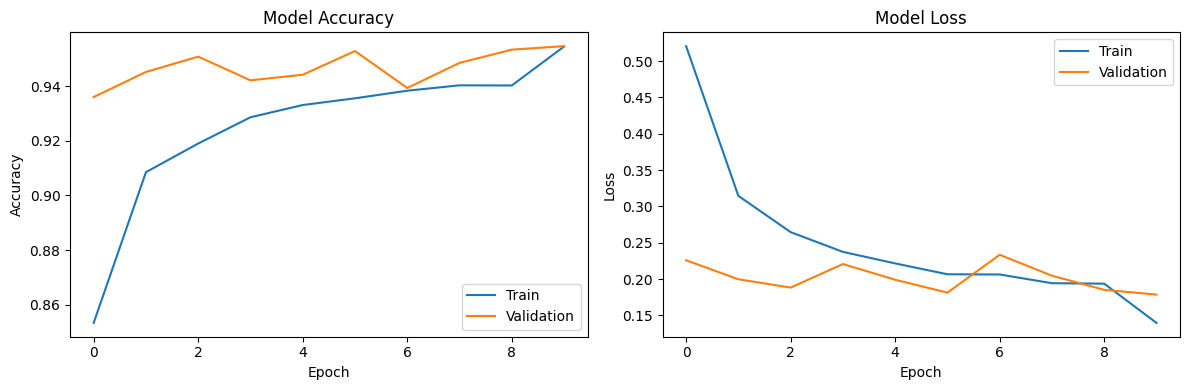

In [20]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

Grafik menunjukkan performa model selama 7 epoch. Model Accuracy menampilkan peningkatan akurasi baik pada data training (biru) maupun validation (oranye), mencapai sekitar 0.95 di epoch terakhir. Model Loss memperlihatkan penurunan kerugian yang signifikan di awal epoch, dengan fluktuasi pada data validation dan penurunan berkelanjutan pada data training.

## Konversi Model

In [21]:
# Direktori untuk menyimpan model-model
models_dir = '/content/models'
saved_model_dir = os.path.join(models_dir, 'saved_model')
tflite_model_path = os.path.join(models_dir, 'model.tflite')
tfjs_model_dir = os.path.join(models_dir, 'tfjs_model')

os.makedirs(models_dir, exist_ok=True)
os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(tfjs_model_dir, exist_ok=True)

#### SavedModel format

In [22]:
tf.saved_model.save(model, saved_model_dir)
print(f"Model saved to {saved_model_dir}")

Model saved to /content/models/saved_model


#### TensorFlow Lite format

In [23]:
# Mengatur optimasi untuk konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"TF-Lite model saved to {tflite_model_path}")

TF-Lite model saved to /content/models/model.tflite


TensorFlow.js format

In [24]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [25]:
import tensorflowjs as tfjs

In [26]:
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"TensorFlow.js model saved to {tfjs_model_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved to /content/models/tfjs_model


## Inference (Optional)

In [27]:
MODEL_PATH = '/content/models/saved_model'

In [28]:
class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

In [29]:
model = tf.saved_model.load(MODEL_PATH)

In [30]:
from google.colab import files

# Mengambil fungsi prediksi dari model yang disimpan
# 'serving_default' adalah tanda tangan (signature) yang digunakan untuk inferensi
predict_fn = model.signatures['serving_default']

# Fungsi upload dan prediksi
def upload_and_predict():
    print("Upload an image for prediction:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Preprocess gambar
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0

        # Mengubah bentuk gambar dari (height, width, channels) menjadi (1, height, width, channels)
        image_batch = np.expand_dims(image, axis=0)

        # Konversi menjadi tensor
        input_tensor = tf.convert_to_tensor(image_batch, dtype=tf.float32)

        # Mengambil nama input dari signature fungsi prediksi
        # structured_input_signature[1] berisi informasi tentang input
        input_name = list(predict_fn.structured_input_signature[1].keys())[0]

        # Buat prediksi
        prediction_dict = predict_fn(**{input_name: input_tensor})
        output_name = list(prediction_dict.keys())[0]
        predictions = prediction_dict[output_name].numpy()

        # Class & confidence
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        # Visualisasi hasil
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.4f}')
        plt.axis('off')
        plt.show()

        print(f"Prediction: {predicted_class} ({confidence:.4f})")

Upload an image for prediction:


Saving tuxedo-cat.jpg to tuxedo-cat.jpg


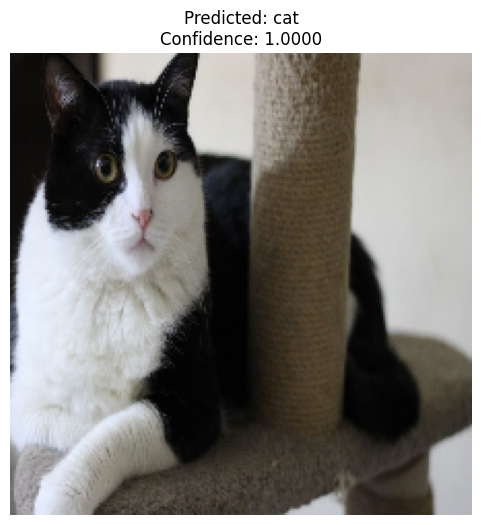

Prediction: cat (1.0000)


In [31]:
upload_and_predict()

Upload an image for prediction:


Saving frame-8.png to frame-8.png


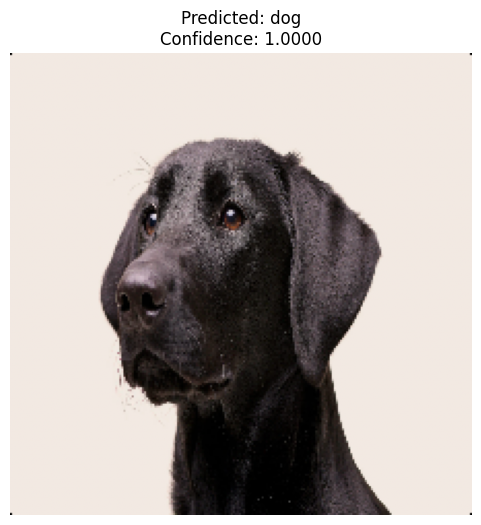

Prediction: dog (1.0000)


In [32]:
upload_and_predict()

Upload an image for prediction:


Saving pjl1zf2bir98gvi.jpeg to pjl1zf2bir98gvi.jpeg


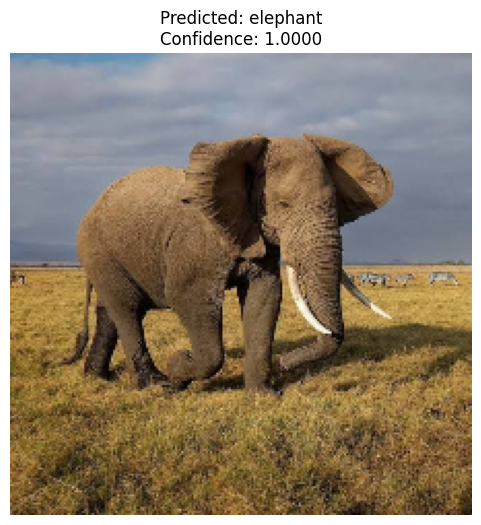

Prediction: elephant (1.0000)


In [33]:
upload_and_predict()

Upload an image for prediction:


Saving pexels-photo-6696645.jpeg to pexels-photo-6696645.jpeg


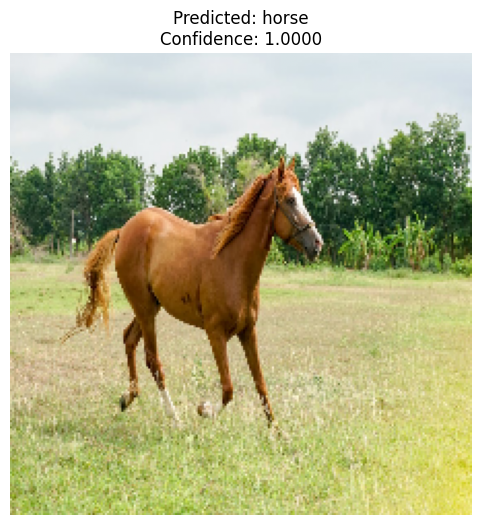

Prediction: horse (1.0000)


In [34]:
upload_and_predict()

Upload an image for prediction:


Saving Ayam_Pelung.jpg to Ayam_Pelung.jpg


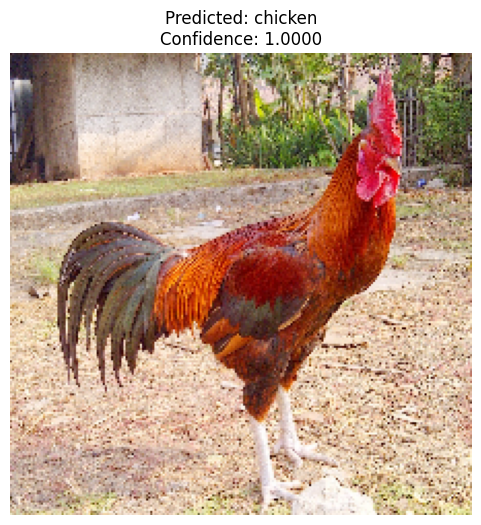

Prediction: chicken (1.0000)


In [35]:
upload_and_predict()

Upload an image for prediction:


Saving wolf-spider.jpg to wolf-spider.jpg


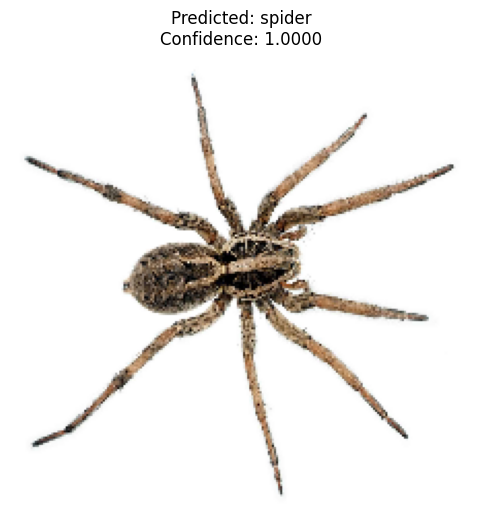

Prediction: spider (1.0000)


In [36]:
upload_and_predict()

Upload an image for prediction:


Saving p06nk1h3.jpg to p06nk1h3.jpg


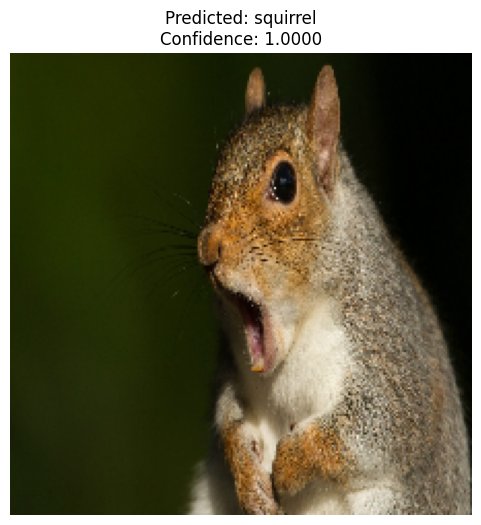

Prediction: squirrel (1.0000)


In [37]:
upload_and_predict()

Upload an image for prediction:


Saving OIP--3xxJkezSkNzxrQaxlhv-QHaHa.jpeg to OIP--3xxJkezSkNzxrQaxlhv-QHaHa.jpeg


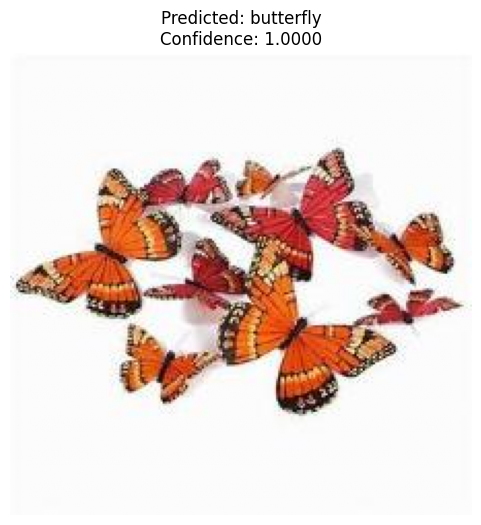

Prediction: butterfly (1.0000)


In [38]:
upload_and_predict()

Upload an image for prediction:


Saving domba.jpeg to domba.jpeg


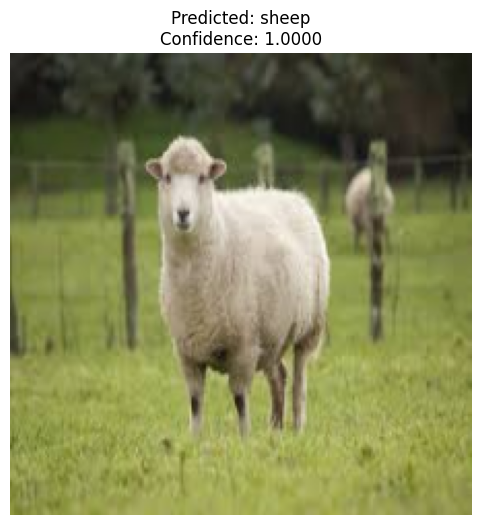

Prediction: sheep (1.0000)


In [39]:
upload_and_predict()

Upload an image for prediction:


Saving mooooo.jpg to mooooo.jpg


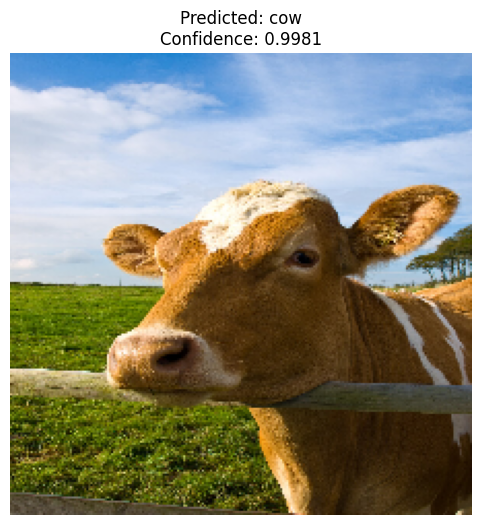

Prediction: cow (0.9981)


In [40]:
upload_and_predict()

In [41]:
# Menyimpan label kelas
labels_path = os.path.join(models_dir, 'labels.txt')
with open(labels_path, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")